# Training Models

We will practice training machine learning models for both regression and for classification problems. 

In [111]:
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline

# 3) Gradient Descent

See notes from Logistic Regression.
Gradient descent marches through the parameter space, evaluating the loss function and attempting to find its global minimum. When the loss function is "well behaved" as *convex* function, the model $\mathbf{w}$ is updated iteratively by searching

$w_j^{(k + 1)} = w_j^{(k)} - \alpha \frac{\partial \mathcal{L}}{\partial w_j}$ for $j = 1 , \cdots , m$



<table><tr>
<td> <img src="GD_cartoon.jpeg" alt="Gradient Descent" style="width: 400px;"/>  </td>
<td> <img src="GD_non_global.png" alt="Gradient Descent non convex" style="width: 400px;"/> </td>
</tr>
<tr>
<td>Gradient descent for a convex, well behaved loss function. </td>
<td> Gradient descent in a poorly behaved loss function with local minima. <td>
</tr>
</table>

**Batch Gradient Descent** is performing the GD over the entire data and taking the steps to go down the gradient by finding the appropriate learning rate $\alpha$. 
<table><tr>
<td> <img src="GD_AlphaTooSmall.png" alt="Learning rate too small" style="width: 400px;"/> </td>
<td> <img src="GD_AlphaTooLarge.png" alt="Learning rate too large" style="width: 400px;"/> </td>
</tr>
<tr>
<td>Learning rate $\alpha$ is too small. It will take longer to converge. </td>
<td> Learning rate $\alpha$ is too large. Converge to global minimum.  <td>
</tr>
</table>
The iteration in GD can be stopped by imposing a convergence rate (tolerance) that is a thershold under which the error will not longer be calculated.

Gradient Descent require re-scaling the data

# 1) Training Regression Models

We will start by fitting regression models. We will download the time series of the GPS station deployed on Montague Island.

<img src="AC29_map.png" alt="AC29 GPS stations on Montague Island" width="600"/>

In [112]:
# Download data
sta="AC29"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # this loops through the days of data
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)
#             # errors
    se.append(float(crap[10])*1000)
    sn.append(float(crap[11])*1000)
    sv.append(float(crap[12])*1000)

  # make dataframe
crap={'station':sta,'date':date,'date_year':date_year,'east':ue,'north':un,'up':uv}
if len(df)==0:
    df = pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])
else:
    df=pd.concat([df,pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])])
df.head()


,station,date,date_year,east,north,up
0,AC29,14AUG18,2014.6283,0.000,0.000,0.000
1,AC29,14AUG19,2014.6311,-2.095,1.439,0.641
2,AC29,14AUG20,2014.6338,-1.860,2.458,2.975
3,AC29,14AUG21,2014.6366,-2.864,3.331,-1.342
4,AC29,14AUG22,2014.6393,-2.541,4.917,1.917


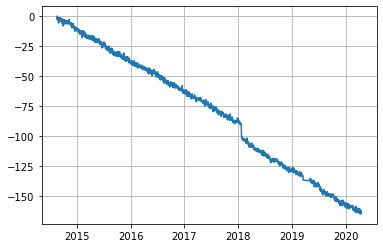

In [113]:
# select the first 2 years of data from the east component
y = ue[0:365*2]
plt.plot(df['date_year'],df['east']);plt.grid(True)

### 1.1 Linear regression

Let $y$ be the data, and $\hat{y}$ be the predicted data. A general linear regression can be formulated as

$\hat{y} = w_0 + w_1 x_1 + ... + w_n x_n = h_w (\mathbf{x})$.

$y$ is a data vector of length $m$, $\mathbf{x}$ is a feature vector of length $m$. $\mathbf{w}$ is a vector of model parameter, $h_w$ is refered to as the *hypothesis function* or the *model* using the model parameter $w$.

To evaluate how well the model performs, we will compute a *loss score*, or a *residual*. It is the result of applying a *loss* or *cost* or *objective* function to the prediction and the data. The most basic *cost function* is the **Mean Square Error (MSE)**:

$MSE(\mathbf{x},h_w) = \frac{1}{m} \sum_{i=1}^{m} \left( h_w(\mathbf{x})_i - y_i  \right)^2$


$MSE(\mathbf{x},h_w) = \frac{1}{m} \sum_{i=1}^{m} \left( \mathbf{w}^T \mathbf{x}_i - y_i  \right)^2$, in the case of a linear regression.

The *Normal Equation* is the solution to the linear regression that minimize the MSE.

$\mathbf{w} = \left( \mathbf{x}^T\mathbf{x} \right)^{-1} \mathbf{x}^T \mathbf{y}$.

It can be solved using Numpy linear algebra module. If $\left( \mathbf{x}^T\mathbf{x} \right) $ is singular and cannot be inverted, a lower rank matrix called the *pseudoinverse* can be calculated using singular value decomposition. We also used in a previous class that the Scikit-learn function for ``sklearn.linear_model.LinearRegression``, which is the implementation of the *pseudoinverse* We practice below how to use these standard inversions:

[[1.     0.    ]
 [1.     0.0028]
 [1.     0.0055]
 ...
 [1.     1.9905]
 [1.     1.9932]
 [1.     1.9959]]
LinearRegression()
modeled parameters. Normal equation
[ -1.46785681 -26.01925682]
modeled parameters. pseudoinverse
[ -1.46785681 -26.01925682]


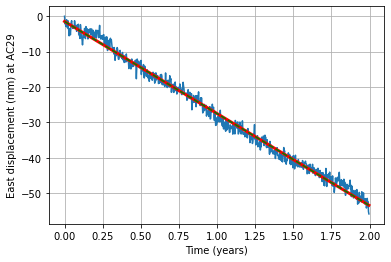

In [114]:
x = np.asarray(date_year[0:2*365]) 
x = x-np.min(x)
y = np.asarray(ue[0:2*365])
G = np.c_[np.ones((2*365,1)),x]
m = len(y)
print(G)

#normal equation
w1 = np.linalg.inv(G.T.dot(G)).dot(G.T).dot(y)

# Pseudo inverse
w2 = np.linalg.pinv(G).dot(y)

# scikitlearn LinearRegression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x.reshape(1,-1),y.reshape(1,-1))
print(lin_reg)
w3 = [lin_reg.intercept_, lin_reg.coef_]

y_predict1=G.dot(w1)
y_predict2=G.dot(w2)
y_predict3=lin_reg.predict(x.reshape(1,-1))

plt.plot(x,y);plt.grid(True)
plt.plot(x,y_predict1,'r',linewidth=3);
plt.plot(x,y_predict2,'g--');
plt.plot(x.reshape(1,-1),y_predict3,'k');
plt.xlabel("Time (years)")
plt.ylabel('East displacement (mm) at AC29')

print("modeled parameters. Normal equation")
print(w1)
print("modeled parameters. pseudoinverse")
print(w2)

## 1.2 Loss Functions for Regressions

Loss functions are used to measure the difference between the data and the predictions. Loss functions are differentiable as

In the previous example, we used the MSE as a loss function:

$\mathcal{L}(\mathbf{w})  = MSE(\mathbf{x},h_w)$

The regression aims to find $h_w$ that minimizes the loss function $\mathcal{L}(\mathbf{w}) $. Other examples of loss functions are:

$MAE(\mathbf{x},h_w) = \frac{1}{m} \sum_{i=1}^m |h_w(x_i) - y_i|$

You can find interesting comparisons of Loss functions for regression problems here: https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0


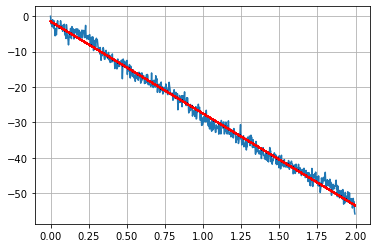

In [108]:
# normalize the data. Without normalization this will fail!
x = np.asarray(date_year[0:2*365]).reshape(-1,1)
y = np.asarray(ue[0:2*365]).reshape(-1,1)
x = x-np.min(x)
G = np.c_[np.ones((len(x),1)),x]
scale = (np.max(y)-np.min(y)) # minmax scaling
newy = y / scale
plt.plot(x,newy*scale);plt.grid(True)

alpha = 0.1
n_iterations =1000
for k in range(100): # perform 100 times the random initialization
    w = np.random.rand(2,1) # initialize the model parameters.
    for iteration in range(n_iterations):
        gradients = 2/m *G.T.dot(G.dot(w)-newy.reshape(-1,1))
        w = w - alpha * gradients  

    plt.plot(x,G.dot(w)*scale,'r')

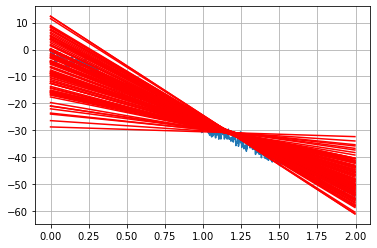

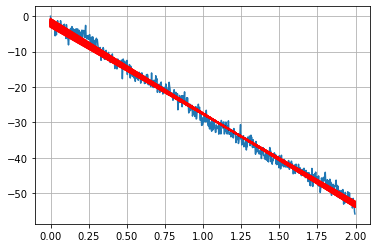

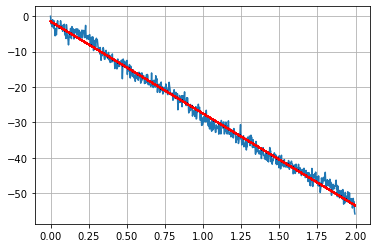

In [109]:
# Now let's vary the learning rate
n_iterations =1000

for alpha in [0.001,0.01,0.1]:
    fig,ax=plt.subplots(1,1)    
    ax.plot(x,newy*scale);ax.grid(True)
    for k in range(100): # perform 100 times the random initialization
        w = np.random.rand(2,1) # initialize the model parameters.
        for iteration in range(n_iterations):
            gradients = 2/m *G.T.dot(G.dot(w)-newy.reshape(-1,1))
            w = w - alpha * gradients  

        ax.plot(x,G.dot(w)*scale,'r')

## 1.3 Stochastic Gradient Descent
SGD takes the gradient for each single instance. By default, SGD in SciKit learn will minimize the MSE cost function.

[-1.5754262735201503, -25.912367303469782]


/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


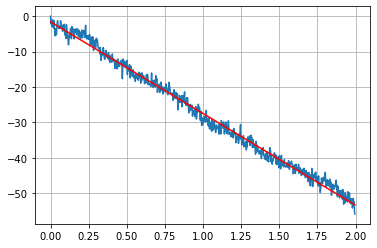

In [110]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor()
sgd_reg.fit(x,y)
w=[sgd_reg.intercept_[0],sgd_reg.coef_[0]]
print(w)

fig,ax=plt.subplots(1,1)    
ax.plot(x,y);ax.grid(True)
ax.plot(x,G.dot(w),'r')

### Mini Batch Gradient Descent
It is a combination of Batch GD and SGD. Minibatch computes the gradient over a subset of instances (as against a single one in SGD or the full one in Batched GD).


# X) Plynomial Regression


# 2) Under-fitting and Overfitting

Whether the model is under or over fitted stems from the tradeoff between variance and bias in the residuals between data and predicted data. It is easier to overfit because scientists tend to overestimate the complexity of the system.

**Underfitting**: the model is too simple. In the case of the simple linear regression, you may ignore the $\theta_i$ where $i>=1$. The solution is to increase the complexity of the model, or to design better feature from the data (feature engineering), and to reduce the constrains on the model (such as the parameterization of model regularization). Underfitting is identified by having a high bias and low variance of the residuals. 

**Overfitting**: Data may contain noise that should not be fit by the algorithm. It happens when the model is too complex relative to the amount and teh noisiness of the training data. The solution is to reduce the moel size, reduce the number of attributes in the training data. Or it is to gather more training data or to reduce the noise in the training data (fix data errors and remove outliers). Constraining a model to make it simpler is called *regularization*. It constrains the model parameter to be small.

High bias and low variance of the residual is a sign of underfitting. High variance and low bias is likely a sign of overfitting.
Regularization

# 3) Regularization

**Bias**
This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.10

**Variance**
This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

**Irreducible error**
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a tradeoff. One way to control the complexity of models is through **regularization**.



## 3.1 Ridge Regression

To regularize the model, we can reduce model parameter variance by imposing that the norm of the model parameters is small. Assuming that the model parameters follow a normal (Gaussian) distribution, we want to minimize the L2 norm (equivalent to the mean square of the model parameters:

$\mathcal{L}(\mathbf{w})  = MSE(\mathbf{w})  + \lambda \frac{1}{2} || \mathbf{w} ||_2^2$, 

where $|| \mathbf{w} ||_2 = \sum_{i=1}^n w_i^2$ is the L2 norm of the model parameters, $\lambda$ is a hyperparameter to tune to balance the contribution of model norm as against the residual norms. L2 norm is sensitive to outliers in the distributions. 
Ridge Regression is sensitive to data scale, so do not forget to scale input data.


## 3.2 Lasso Regression
Lasso Regression is just like the Ridge Regression a way to minimize model variance. Instead of mimizing the L2 norm, we mimize the L1 norn:

$\mathcal{L}(\mathbf{w})  = MSE(\mathbf{w})  + \lambda  || \mathbf{w} ||_1^2$, 

The L1 norm $|| \mathbf{w} ||_1 = \sum_{i=1}^n | w_i |$ is appropriate for exponential (Laplace) distribution, and allow to not be penalized by outliers. It tends to eliminate the weights of the least important features. It effectively performs a *feature reduction* and output a *sparse model*. It can be called in SGD by using the argument ``penalty="l1"``.


## 3.3 Elastic Net

Combine Ridge and Lasso, weigh the contribution of each norm (L1 and L2) using the hyperparameter $r$, and the contribution of the regularization in the loss function with $\lambda$.

$\mathcal{L}(\mathbf{w})  = MSE(\mathbf{w})  + r  \lambda|| \mathbf{w} ||_1 + \frac{1-r}{2}  \lambda|| \mathbf{w} ||_2^2$, 

[1.3060498505873803, -28.15804923617975] [1.3020249866927003, array([-28.21907473])] [1.1549214831474544, -28.14542351286437] [-0.8073373888433579, -27.162967222544776]


/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-126-5305b185c70d>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(x,G.dot(w_ridge))


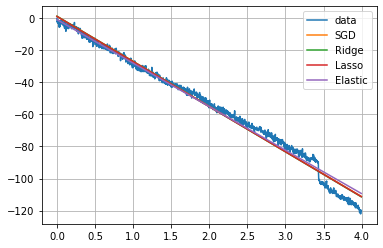

In [126]:
from sklearn.linear_model import SGDRegressor, ElasticNet, Lasso, Ridge
sgd_reg = SGDRegressor()
ridge_reg = Ridge(alpha=0.1)
lasso_reg = Lasso(alpha=0.1)
ela_reg = ElasticNet(alpha=0.1,l1_ratio=0.5)

# prep the data again
x = np.asarray(date_year[0:4*365]).reshape(-1,1)
y = np.asarray(ue[0:4*365]).reshape(-1,1)
x = x-np.min(x)
G = np.c_[np.ones((len(x),1)),x]
scale = (np.max(y)-np.min(y)) # minmax scaling


sgd_reg.fit(x,y)
ridge_reg.fit(x,y)
lasso_reg.fit(x,y)
ela_reg.fit(x,y)
y_sgd=sgd_reg.predict(x)
y_sridge=ridge_reg.predict(x)
y_lasso=lasso_reg.predict(x)
y_ela=ela_reg.predict(x)

w_sgd=[sgd_reg.intercept_[0],sgd_reg.coef_[0]]
w_ridge=[ridge_reg.intercept_[0],ridge_reg.coef_[0]]
w_lasso=[lasso_reg.intercept_[0],lasso_reg.coef_[0]]
w_ela=[ela_reg.intercept_[0],ela_reg.coef_[0]]
print(w_sgd,w_ridge,w_lasso,w_ela)

fig,ax=plt.subplots(1,1)    
ax.plot(x,y);ax.grid(True)
ax.plot(x,G.dot(w_sgd))
ax.plot(x,G.dot(w_ridge))
ax.plot(x,G.dot(w_lasso))
ax.plot(x,G.dot(w_ela))
ax.legend(['data','SGD','Ridge','Lasso','Elastic'])

In [203]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y,c1,c2):
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), c1, linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors),c2, linewidth=3, label="val")
    plt.legend(['training','validation'])
    plt.grid(True)
    plt.ylabel("MSE")


/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/Users/marinedenolle/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


(0.0, 20.0)

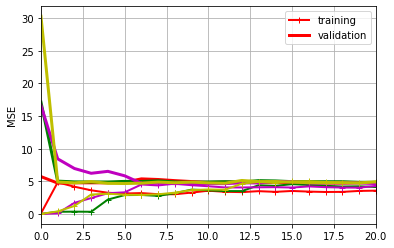

In [204]:
# perform the regressions
plot_learning_curves(sgd_reg, x.ravel(), y.ravel(),"r-+","r")
plot_learning_curves(ridge_reg, x.ravel(), y.ravel(),"g-+","g")
plot_learning_curves(lasso_reg, x.ravel(), y.ravel(),"m-+","m")
plot_learning_curves(ela_reg, x.ravel(), y.ravel(),"y-+","y")
plt.xlim([0,20])

Now we will look at the vertical component of the GPS. It usually has smaller signal that horizontal motions at plate boundaries. It is also a lot more sensitive to surface loads such as seasonal surface snow and hydrology. The GPS vertical measurement is noisier than the horizontal measurement, and thus tends to be less used. But in the intersection of geodesy and hydrology, GPS is increasingly used to monitor drought effects on crustal deformation.



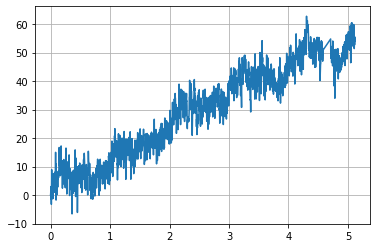

In [205]:
# normalize the data. Without normalization this will fail!
x = np.asarray(date_year[0:5*365]).reshape(-1,1)
y = np.asarray(uv[0:5*365]).reshape(-1,1)
x = x-np.min(x)
G = np.c_[np.ones((len(x),1)),x]
scale = (np.max(y)-np.min(y)) # minmax scaling
newy = y / scale
plt.plot(x,newy*scale);plt.grid(True)


The data looks complex, with the superposition of a linear trend and oscillatory signals. Let's fit a general polynomial form. We will start with a simple model.

(1825, 3)


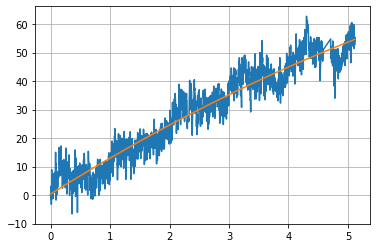

In [206]:
from sklearn.preprocessing import PolynomialFeatures


#Let's start with a simple
poly_features = PolynomialFeatures(degree=2)
G = poly_features.fit_transform(x) # G now contains the original feature of X plus the power of the features.


ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(G,y)
y_ridge=ridge_reg.predict(G)
print(G.shape)

plt.plot(x,y);plt.grid(True)
plt.plot(x,y_ridge)

(0.0, 200.0)

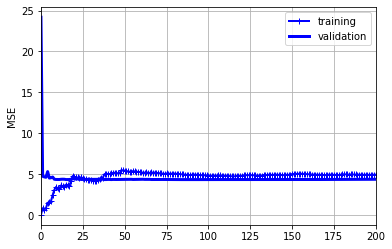

In [207]:
plot_learning_curves(ridge_reg, G.ravel(), y.ravel(),"b-+","b");plt.xlim([0,200])

(0.0, 200.0)

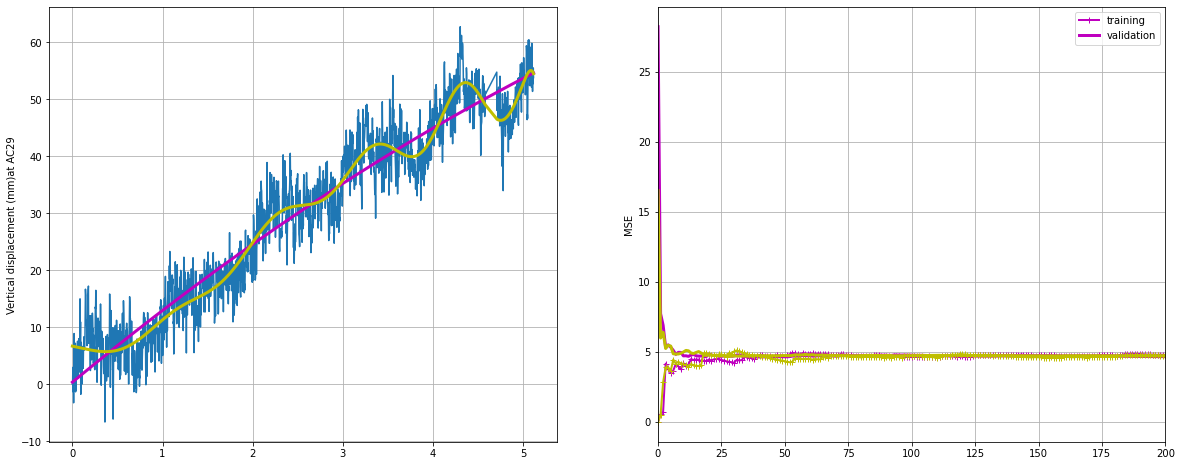

In [211]:
# Let's make it complex
poly_features = PolynomialFeatures(degree=20)
G2 = poly_features.fit_transform(x) # G now contains the original feature of X plus the power of the features.


ridge_reg2 = Ridge(alpha=0.75)
ridge_reg2.fit(G2,y)
y_ridge2=ridge_reg2.predict(G2)

fix,ax=plt.subplots(1,2,figsize=(20,8))
ax[0].plot(x,y);ax[0].grid(True)
ax[0].plot(x,y_ridge,"m",linewidth=3)
ax[0].plot(x,y_ridge2,"y",linewidth=3)
ax[0].set_ylabel('Vertical displacement (mm)at AC29')
plot_learning_curves(ridge_reg, G.ravel(), y.ravel(),"m-+","m");plt.xlim([0,200])
plot_learning_curves(ridge_reg, G2.ravel(), y.ravel(),"y-+","y");plt.xlim([0,200])

## When to stop training

SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty='l1',
             tol=-inf, warm_start=True)


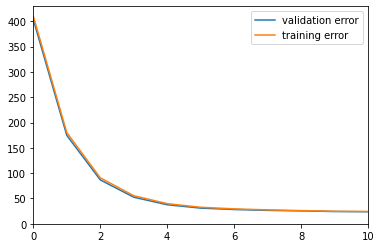

In [242]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

x = np.asarray(date_year[0:5*365]).reshape(-1, 1)
y = np.asarray(uv[0:5*365]).reshape(-1, 1)
x = x-np.min(x)
# prepare the data

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=20, include_bias=False)),
        ("std_scaler", StandardScaler()) ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_poly = poly_scaler.fit_transform(x)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty="l1", learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
val_error=np.zeros(1000)
train_error=np.zeros(1000)
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    val_error[epoch] = mean_squared_error(y_val, y_val_predict)
    train_error[epoch] = mean_squared_error(y_train, y_train_predict)
    if val_error[epoch] < minimum_val_error:
        minimum_val_error = val_error[epoch]
        best_epoch = epoch
        best_model = clone(sgd_reg)
        best_y = sgd_reg.predict(X_poly)
plt.plot(np.arange(1000),val_error)
plt.plot(np.arange(1000),train_error)
plt.legend(["validation error","training error"])
plt.xlim([0,10])

print(best_model)

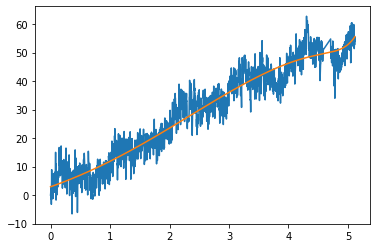

In [240]:
plt.plot(x,y);
plt.plot(x,best_y)

# Let's work on this.


Implement a model fitting of the horizontal data. Find the velocity of convergence.

Perform a polynomial regression. Explore the regularized regressions.

Explore the choice of the loss function between MSE and MAE.

Explore the training set - test set split. Perform K-folds cross validation.

Vary initialization of the model parameters.

Train over 100 epochs.

Plot the learning curve and the validation+training error.

Explore the effects of regularization.
